<a href="https://colab.research.google.com/github/chunjie-sam-liu/TEP-prognosis/blob/main/08_DeepSurvOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install torchtuples
! pip install pycox
! pip install hiddenlayer

In [2]:
import os

import numpy as np
# Data import
import feather
import matplotlib.pyplot as plt
%matplotlib inline

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
from torch import nn
import torchtuples as tt
import torch.nn.functional as F
from torch.nn.modules.linear import Linear

from pycox.models import LogisticHazard, CoxPH
from pycox.models.loss import NLLLogistiHazardLoss
from pycox.evaluation import EvalSurv


In [3]:
np.random.seed(1234)
torch.manual_seed(1234)

In [4]:
# Load data and label transformation
def load_data(filepath):
    df = feather.read_dataframe(source=filepath)
    df_train = df.loc[df.oc == "OC521"].drop(columns=["barcode", "oc"], axis=1)
    df_val = df.loc[df.oc == "OC44"].drop(columns=["barcode", "oc"], axis=1)
    df_test1 = df.loc[df.oc == "OC79"].drop(columns=["barcode", "oc"], axis=1)
    df_test2 = df.loc[df.oc == "OC172"].drop(columns=["barcode", "oc"], axis=1)
    return df_train, df_val, df_test1, df_test2


def get_target(df):
    dd = np.array([i if i < 100 else 100 for i in df['duration'].values])
    print(dd.max())
    return (dd, df["event"].values)


def transform_features(df_train, df_val, df_test1, df_test2):
    columns = df_train.columns
    columns = columns[: len(columns) - 2]
    standardize = [([col], StandardScaler()) for col in columns]

    x_mapper = DataFrameMapper(standardize)

    x_train = x_mapper.fit_transform(df_train).astype("float32")
    x_val = x_mapper.transform(df_val).astype("float32")
    x_test1 = x_mapper.transform(df_test1).astype("float32")
    x_test2 = x_mapper.transform(df_test2).astype("float32")

    return x_train, x_val, x_test1, x_test2


def transform_labels(df_train, df_val, nd=10):
    num_durations = nd
    labtrans = LogisticHazard.label_transform(num_durations)
    y_train_surv = labtrans.fit_transform(*get_target(df_train))
    y_val_surv = labtrans.transform(*get_target(df_val))

    return y_train_surv, y_val_surv, labtrans

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
filepath="/content/drive/MyDrive/colab-data/total416.os.se.norm.coxph.feather"

In [7]:
# load data
df_train, df_val, df_test1, df_test2 = load_data(filepath)
# transform features
x_train, x_val, x_test1, x_test2 = transform_features(df_train, df_val, df_test1, df_test2)
# transform labels
# y_train_surv, y_val_surv, labtrans = transform_labels(df_train, df_val)

In [8]:
y_train = get_target(df_train)
y_val = get_target(df_val)

durations_test1, events_test1 = get_target(df_test1)
durations_test2, events_test2 = get_target(df_test2)

100.0
100.0
100.0
100.0


In [9]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout, output_bias=output_bias)

In [10]:
net

MLPVanilla(
  (net): Sequential(
    (0): DenseVanillaBlock(
      (linear): Linear(in_features=40, out_features=32, bias=True)
      (activation): ReLU()
      (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): DenseVanillaBlock(
      (linear): Linear(in_features=32, out_features=32, bias=True)
      (activation): ReLU()
      (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (2): Linear(in_features=32, out_features=1, bias=False)
  )
)

In [11]:
model = CoxPH(net, tt.optim.Adam)

In [12]:
#model.load_model_weights(path="/content/drive/MyDrive/colab-data/os.model")

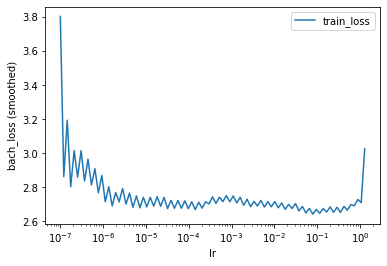

In [20]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [21]:
lrfinder.get_best_lr()

0.007924828983539215

In [22]:
model.optimizer.set_lr(lrfinder.get_best_lr())

In [23]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [24]:
val = x_val, y_val

In [17]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 3.4066,	val_loss: 2.2135
1:	[0s / 0s],		train_loss: 3.1120,	val_loss: 2.1247
2:	[0s / 0s],		train_loss: 3.2405,	val_loss: 1.9705
3:	[0s / 0s],		train_loss: 2.8849,	val_loss: 2.0827
4:	[0s / 0s],		train_loss: 2.7943,	val_loss: 2.0994
5:	[0s / 0s],		train_loss: 2.6285,	val_loss: 2.0685
6:	[0s / 0s],		train_loss: 2.9233,	val_loss: 2.1195
7:	[0s / 0s],		train_loss: 2.9507,	val_loss: 2.1676
8:	[0s / 0s],		train_loss: 2.6926,	val_loss: 2.1815
9:	[0s / 0s],		train_loss: 2.8066,	val_loss: 2.0899
10:	[0s / 0s],		train_loss: 2.5959,	val_loss: 1.9739
11:	[0s / 0s],		train_loss: 2.6083,	val_loss: 1.8775
12:	[0s / 0s],		train_loss: 2.6693,	val_loss: 1.8333
13:	[0s / 0s],		train_loss: 2.6909,	val_loss: 1.8821
14:	[0s / 0s],		train_loss: 2.6295,	val_loss: 1.9598
15:	[0s / 0s],		train_loss: 2.5584,	val_loss: 2.0204
16:	[0s / 0s],		train_loss: 2.6612,	val_loss: 2.0652
17:	[0s / 0s],		train_loss: 2.4228,	val_loss: 2.0645
18:	[0s / 0s],		train_loss: 2.4516,	val_loss: 2.0796
19:

In [25]:
_ = log.plot()

NameError: ignored

In [26]:
model.partial_log_likelihood(*val).mean()

-1.8333481550216675

In [27]:
_ = model.compute_baseline_hazards()

In [28]:
model.predict(x_test1[[0]])

array([[0.43749356]], dtype=float32)

In [29]:
surv = model.predict_surv_df(x_test1)

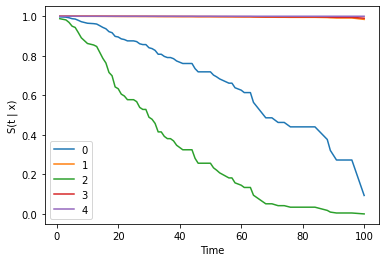

In [30]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


0.8801089918256131
0.8801089918256131
0.10060788792058162


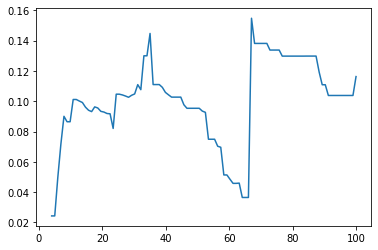

In [31]:
surv1 = model.predict_surv_df(x_test1)
ev1 = EvalSurv(surv1, durations_test1, events_test1, censor_surv='km')
print(ev1.concordance_td())
print(ev1.concordance_td('adj_antolini'))
time_grid = np.linspace(durations_test1.min(), durations_test1.max(), 100)
_ = ev1.brier_score(time_grid).plot()
print(ev1.integrated_brier_score(time_grid))

0.8261904761904761
0.8261904761904761
0.15453652124856196


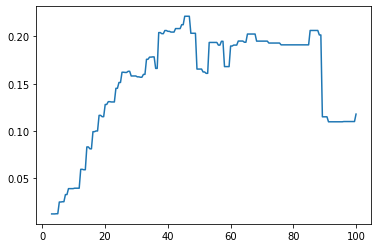

In [32]:
surv2 = model.predict_surv_df(x_test2)
ev2 = EvalSurv(surv2, durations_test2, events_test2, censor_surv='km')
print(ev2.concordance_td())
print(ev2.concordance_td('adj_antolini'))
time_grid = np.linspace(durations_test2.min(), durations_test2.max(), 200)
_ = ev2.brier_score(time_grid).plot()
print(ev2.integrated_brier_score(time_grid))

100.0
0.8710787290022263
0.8710787290022263
0.10997982438436375


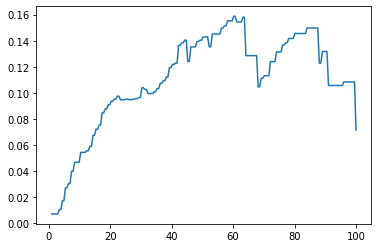

In [26]:
durations_train, events_train = get_target(df_train)
surv = model.predict_surv_df(x_train)
ev = EvalSurv(surv, durations_train, events_train, censor_surv='km')
print(ev.concordance_td())
print(ev.concordance_td('adj_antolini'))
time_grid = np.linspace(durations_train.min(), durations_train.max(), 200)
_ = ev.brier_score(time_grid).plot()
print(ev.integrated_brier_score(time_grid))

100.0
0.8591549295774648
0.8591549295774648
0.15645752956792844


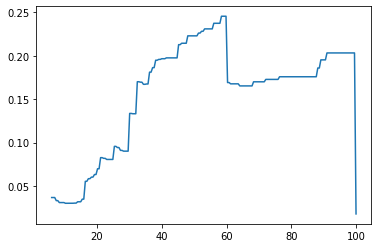

In [27]:
durations_val, events_val = get_target(df_val)
surv = model.predict_surv_df(x_val)
ev = EvalSurv(surv, durations_val, events_val, censor_surv='km')
print(ev.concordance_td())
print(ev.concordance_td('adj_antolini'))
time_grid = np.linspace(durations_val.min(), durations_val.max(), 200)
_ = ev.brier_score(time_grid).plot()
print(ev.integrated_brier_score(time_grid))

In [32]:
model.save_model_weights(path="/content/drive/MyDrive/colab-data/os.model")